# Comments

In [1]:
# It should take less than about 35 s to run the
# entire notebook under the default settings.

# Import appropriate packages and set analysis options.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
import seaborn as sns
sns.set(color_codes=True)
from sklearn import metrics, preprocessing, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from math import sqrt

# Setting randomize_seeding to True will
# randomize various operations throughout
# the notebook. Setting it to False will
# cause the seed to remain fixed to some
# specified value such that the notebook
# can be reran with the same randomized
# variables (see MAGIC_SEED below).
randomize_seeding = False

# Define convenient variables and functions.

In [3]:
# These paths indicate from where the training
# data will be loaded.
DATA_PATH = "./data/wine.data"

# The MAGIC_SEED optionally specifies a fixed
# random state/seed so that the notebook can be
# reran with the same randomized variables (see
# randomize_seeding above).
MAGIC_SEED = 1776
if (randomize_seeding):
    MAGIC_SEED = np.random.seed()

# The training data provided with this data
# set will be split into two subsets so that
# models can be trained on the first and tested
# on the second. TRAINING_DATA_TEST_SIZE
# indicates the proportion of the training
# data that will be used as test data for
# model evaluation and should be in the
# range [0.0, 1.0].
TRAINING_DATA_TEST_SIZE = 0.50

def load_data(path, header_names):
    """
    Load the file at 'path' into a Pandas
    DataFrame.
    """
    df = pd.read_csv(path, header=None, names=header_names)
    print("Loaded data dimensions: ", df.shape[0], "rows, ", df.shape[1], "columns")
    return df

def print_nan(nan_cols_counts, col_type):
    """
    Print each element of the list which should contain
    a DataFrame feature name and an int number of times
    the feature contains an NaN value.
    """
    print("\n", len(nan_cols_counts), " ", col_type, "-type columns with NaN values.", sep='')
    if(len(nan_cols_counts) > 0):
        print("    {:<16}{}".format("Feature", "NaN Count"))
        print("%s" % "    ---------------------")
    for index, element in enumerate(nan_cols_counts):
        print("{:>2}. {:<16}{}".format(index+1, element[0], element[1]))
        
def gather_nan(df, col_type, print_if_nan = True):
    """
    Find all DataFrame columns of type 'col_type'
    which contain NaN values.
    """
    if (col_type == "int"):
        columns = df.select_dtypes(include=['int']).columns
    elif (col_type == "float"):
        columns = df.select_dtypes(include=['float']).columns
    else:
        columns = df.select_dtypes(include=['object']).columns
    nan_cols_counts = []
    for col in np.sort(columns):
        num_nan = np.sum(df[col].isnull())
        if (num_nan > 0):
            nan_cols_counts.append((col, num_nan))
    if (print_nan):
        print_nan(nan_cols_counts, col_type)
    return nan_cols_counts

def evaluate_model(x_data, y_data, model, add_title = True):
    """
    Given an input model and data,
    split the data into training/testing subsets
    and use this to produce a fit and predictions.
    Indicate the goodness of the fit and plot
    the results.
    """
    # Split the data into two subsets.
    # Then, train the model on the target data
    # and use it to predict results.
    x_data1, x_data2, y_data1, y_data2 = train_test_split(
        x_data, y_data,
        test_size=TRAINING_DATA_TEST_SIZE,
        random_state=MAGIC_SEED)
    model.fit(x_data1, y_data1)
    y_data2_pred = model.predict(x_data2)
    
    # Evaluate the model & predictions by viewing
    # the cross-validation score, error, and
    # variance (where a variance of 1 indicates
    # a perfect prediction) and plotting the results.
    print("When using %0.1f%% of the data to perform the"
        " fit and %0.1f%% of the data to make the prediction,"
        " the model performed according to the following:"
        % (100.0*(1.0-TRAINING_DATA_TEST_SIZE), 100.0*TRAINING_DATA_TEST_SIZE))
    print(cross_val_score(model, x_data1, y_data1, cv=5))
    print("RMS Error: %.3f"
        % sqrt(metrics.mean_squared_error(y_data2, y_data2_pred)))
    print('Variance score: %.3f' % metrics.r2_score(y_data2, y_data2_pred))
    x = np.arange(6)
    y = [y_data2.tolist().count(1), y_data2_pred.tolist().count(1),
         y_data2.tolist().count(2), y_data2_pred.tolist().count(2),
         y_data2.tolist().count(3), y_data2_pred.tolist().count(3)]
    colors = ("green", "cyan", "red", "magenta", "black", "gray")
    plt.bar(x, y, color=colors)
    plt.xticks(x, ("True Class1", "Pred. Class1", "True Class2", "Pred. Class2",
        "True Class3", "Pred. Class3"))
    if add_title:
        plt.title('k = %d' % model.get_params()['n_neighbors'])
    plt.show()
    
    # Finalize the model by fitting it to the entire data set.
    model.fit(x_data, y_data)
    
    # Return a score for this model.
    return metrics.accuracy_score(y_data2, y_data2_pred)

# Load and preview the wine data.

In [4]:
df = load_data(DATA_PATH, ['Class', 'Alcohol', 'Acid', 'Ash', 'Alcalinity', 'Magnesium', 'TotPhenols', 'Flavanoids', 'NonflavPhenols', 'Proanth', 'ColIntensity', 'Hue', 'OD', 'Proline'])
df.head()

Loaded data dimensions:  178 rows,  14 columns


,Class,Alcohol,Acid,Ash,Alcalinity,Magnesium,TotPhenols,Flavanoids,NonflavPhenols,Proanth,ColIntensity,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
df.describe()

,Class,Alcohol,Acid,Ash,Alcalinity,Magnesium,TotPhenols,Flavanoids,NonflavPhenols,Proanth,ColIntensity,Hue,OD,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


### The data has several features with min or max values beyond three standard deviations from the mean - an indicator of outliers. Also, since feature values span about three orders of magnitude, the data should be scaled  to ensure easier convergence for fitting.

# Clean and process the data.

In [6]:
# Partition data into features (X-data) and
# targets (Y-data).
x_data = df.iloc[:,1:]
y_data = df.iloc[:,0]

# Determine which features have missing values.
nan_int_cols = gather_nan(x_data, "int")
nan_float_cols = gather_nan(x_data, "float")
nan_string_cols = gather_nan(x_data, "string")


0 int-type columns with NaN values.

0 float-type columns with NaN values.

0 string-type columns with NaN values.


### The data is already tidy!

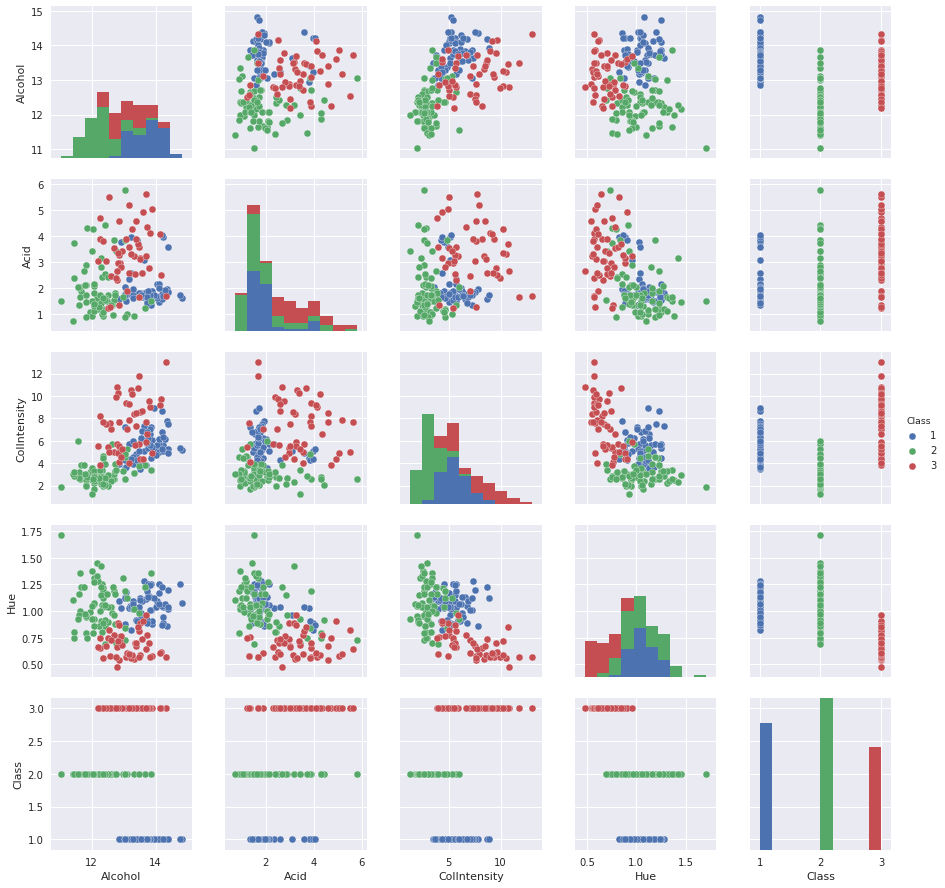

In [7]:
# Plot the wine class as a function of multiple
# features - Alcohol, Acid, ColIntensity, and
# Hue - to get an idea of how various features
# influence classification.
pair_features = pd.concat([x_data[['Alcohol','Acid','ColIntensity', 'Hue']],
    pd.DataFrame(y_data)], axis='columns')
sns.pairplot(data=pair_features, hue="Class")

In [8]:
# Since several of the categories contain outliers
# (i.e. > 3 standard deviations from the mean), use
# a robust scaling method which accounts for outliers.
robust_scaler = preprocessing.RobustScaler()
x_data['Alcohol'] = robust_scaler.fit_transform(x_data['Alcohol'].values.reshape(-1,1))
x_data['Alcalinity'] = robust_scaler.fit_transform(x_data['Alcalinity'].values.reshape(-1,1))
x_data['Magnesium'] = robust_scaler.fit_transform(x_data['Magnesium'].values.reshape(-1,1))
x_data['ColIntensity'] = robust_scaler.fit_transform(x_data['ColIntensity'].values.reshape(-1,1))
x_data['Proline'] = robust_scaler.fit_transform(x_data['Proline'].values.reshape(-1,1))

# View the data to ensure everything scaled properly.
x_data.describe()

,Alcohol,Acid,Ash,Alcalinity,Magnesium,TotPhenols,Flavanoids,NonflavPhenols,Proanth,ColIntensity,Hue,OD,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,1.780000e+02,178.000000,178.000000,178.000000
mean,-0.037553,2.336348,2.366517,-0.001176,0.091662,2.295112,2.029270,0.361854,1.590899,1.235201e-01,0.957449,2.611685,0.151482
std,0.617359,1.117146,0.274344,0.776643,0.751710,0.625851,0.998859,0.124453,0.572359,7.779483e-01,0.228572,0.709990,0.649964
min,-1.536122,0.740000,1.360000,-2.069767,-1.473684,0.980000,0.340000,0.130000,0.410000,-1.144295e+00,0.480000,1.270000,-0.816305
25%,-0.522814,1.602500,2.210000,-0.534884,-0.526316,1.742500,1.205000,0.270000,1.250000,-4.932886e-01,0.782500,1.937500,-0.357069
50%,0.000000,1.865000,2.360000,0.000000,0.000000,2.355000,2.135000,0.340000,1.555000,1.489694e-16,0.965000,2.780000,0.000000
75%,0.477186,3.082500,2.557500,0.465116,0.473684,2.800000,2.875000,0.437500,1.950000,5.067114e-01,1.120000,3.170000,0.642931
max,1.353612,5.800000,3.230000,2.441860,3.368421,3.880000,5.080000,0.660000,3.580000,2.788591e+00,1.710000,4.000000,2.077399


# Evaluate and compare various models.

## Method #1: k-Nearest Neighbors (kNN)

In [9]:
estimator = KNeighborsClassifier()

## Perform hyperparameter tuning for a kNN model using a grid search w/ cross-validation.

When using 50.0% of the data to perform the fit and 50.0% of the data to make the prediction, the model performed according to the following:
[1.         0.89473684 0.94444444 0.82352941 1.        ]
RMS Error: 0.260
Variance score: 0.880


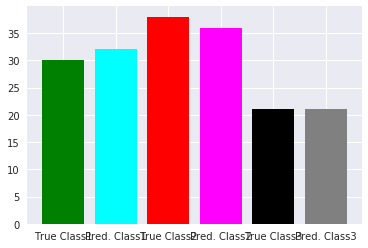

The best parameters are:
{'n_neighbors': 1}
with a score of 0.978


In [10]:
k_values = list(range(1,25))
parameter_grid = {
    "n_neighbors": k_values
}
model_knn = GridSearchCV(estimator, cv=5, return_train_score=True,
    param_grid=parameter_grid)
evaluate_model(x_data, y_data, model_knn, False)
print("The best parameters are:")
print(model_knn.best_params_)
print("with a score of %.3f" % model_knn.best_score_)

## Method #2: Support Vector Machine (SVM)

In [11]:
estimator = svm.SVC()

## Perform hyperparameter tuning for a SVM model using a grid search w/ cross-validation.

When using 50.0% of the data to perform the fit and 50.0% of the data to make the prediction, the model performed according to the following:
[1.         0.94736842 0.94444444 0.94117647 0.9375    ]
RMS Error: 0.184
Variance score: 0.940


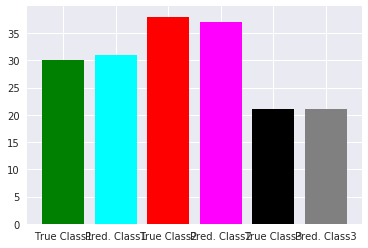

The best parameters are:
{'coef0': 0.0, 'kernel': 'rbf', 'tol': 0.001}
with a score of 0.983


In [12]:
parameter_grid = {
    "kernel": ['linear', 'rbf'],
    "coef0": [0.0, 1.0],
    "tol": [1e-3, 1e-4]
}
model_svm = GridSearchCV(estimator, cv=5, return_train_score=True,
    param_grid=parameter_grid)
evaluate_model(x_data, y_data, model_svm, False)
print("The best parameters are:")
print(model_svm.best_params_)
print("with a score of %.3f" % model_svm.best_score_)

### Both models perform reasonably well when trained on half the data, but the SVM consistently outperforms the kNN model. The SVM is therefore probably the preferred classifier for this data set.

In [13]:
# How well does the kNN model perform
# on the full data set?
y_pred = model_knn.predict(x_data)
metrics.accuracy_score(y_data, y_pred)

1.0

In [14]:
# How well does the SVM model perform on the full
# data set?
y_pred = model_svm.predict(x_data)
metrics.accuracy_score(y_data, y_pred)

0.9887640449438202

### After being trained on the full data set, both the kNN and the SVM models perfectly (or nearly perfectly) predict all classifications. This is likely a  symptom of overfitting, and both models would need to be cross-validated using additional data.